## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [7]:
!ls -l complaints.json

ls: cannot access 'complaints.json': No such file or directory


In [8]:
pip install swifter

In [9]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser', 'ner'])
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import swifter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

stopwords = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

from wordcloud import WordCloud
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
plt.rcParams['figure.figsize']=(10,10) 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [12]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [13]:
# Opening JSON file 
f = open('/content/drive/My Drive/app/NLP Assignment/complaints.json')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [14]:
df.shape

(78313, 22)

In [15]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [16]:
df.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [17]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [18]:
#Assign new column names
df.rename(mapper=lambda x:x[1:] if '_source' not in x else x[8:], axis='columns', inplace=True)
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [19]:
#Assign nan in place of blanks in the complaints column
df.loc[df[df['complaint_what_happened'].str.strip()==''].index, 'complaint_what_happened'] = np.nan

In [20]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

In [21]:
df.reset_index(inplace=True)

In [22]:
df.shape

(21072, 23)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [23]:
sample_text = df.loc[463]['complaint_what_happened']
sample_text

'onXXXX XXXX odf XXXX Chase decided to tell the credit bureaus that my account was in a bankruptcy. This violates section 15 U.S.C. 2 1681 c [ a ] [ 1 ]. This can not be repoerted with any mention of a BK. They have also erased my pay history, even though i paid the for 13 years. This hurts my credit and it is violating the federal rules.The BK was filed over 10 years ago.'

In [24]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
  #Make the text lowercase
  text = text.lower()
  #Remove text in square brackets
  text = re.sub(r'\[.*\]', '', text)
  #Remove punctuation
  text = re.sub(r'[^\w\s]', '', text)
  #Remove words containing numbers
  text = re.sub(r'\s?\w*\d+\w*\s?', '', text)
  return text

clean_text(sample_text)

'onxxxx xxxx odf xxxx chase decided to tell the credit bureaus that my account was in a bankruptcy this violates sectionuscc  this can not be repoerted with any mention of a bk they have also erased my pay history even though i paid the foryears this hurts my credit and it is violating the federal rulesthe bk was filed overyears ago'

In [25]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):
  #Lemmatize the texts

  # doc = nlp(text)
  # return ' '.join(token.lemma_ for token in doc if token not in stopwords)
  
  sent = [wordnet_lemmatizer.lemmatize(word) for word in word_tokenize(text) if not word in stopwords]
  return ' '.join(sent)

lemmatize_text(clean_text(sample_text))

'onxxxx xxxx odf xxxx chase decided tell credit bureau account bankruptcy violates sectionuscc repoerted mention bk also erased pay history even though paid foryears hurt credit violating federal rulesthe bk filed overyears ago'

In [26]:
df['complaint_text_clean'] = df['complaint_what_happened'].swifter.apply(clean_text)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [27]:
df['complaint_text_lemmatized'] = df['complaint_text_clean'].swifter.apply(lemmatize_text)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [ ]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 


In [28]:
df_clean = df[['complaint_text_clean', 'complaint_text_lemmatized']]
df_clean.head()

,complaint_text_clean,complaint_text_lemmatized
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
1,i upgraded my xxxx xxxx card inand was told by...,upgraded xxxx xxxx card inand told agent upgra...
2,chase card was reported onhowever fraudulent a...,chase card reported onhowever fraudulent appli...
3,onwhile trying to book a xxxx xxxx ticket i ...,onwhile trying book xxxx xxxx ticket came acro...
4,my grand son give me check fori deposit it int...,grand son give check fori deposit chase accoun...


In [29]:
pos_tag(word_tokenize(lemmatize_text(clean_text(sample_text))))

[('onxxxx', 'JJ'),
 ('xxxx', 'NNP'),
 ('odf', 'MD'),
 ('xxxx', 'VB'),
 ('chase', 'NN'),
 ('decided', 'VBD'),
 ('tell', 'NN'),
 ('credit', 'NN'),
 ('bureau', 'NN'),
 ('account', 'NN'),
 ('bankruptcy', 'NN'),
 ('violates', 'VBZ'),
 ('sectionuscc', 'RB'),
 ('repoerted', 'VBN'),
 ('mention', 'NN'),
 ('bk', 'NN'),
 ('also', 'RB'),
 ('erased', 'VBD'),
 ('pay', 'NN'),
 ('history', 'NN'),
 ('even', 'RB'),
 ('though', 'IN'),
 ('paid', 'VBN'),
 ('foryears', 'NNS'),
 ('hurt', 'VBN'),
 ('credit', 'NN'),
 ('violating', 'VBG'),
 ('federal', 'JJ'),
 ('rulesthe', 'NN'),
 ('bk', 'NN'),
 ('filed', 'VBD'),
 ('overyears', 'NNS'),
 ('ago', 'RB')]

In [30]:
#Write your function to extract the POS tags 

def postag(text):
  # write your code here

  # doc = nlp(text)
  # return ' '.join([token.text for token in doc if token.tag_ == 'NN'])

  tags = pos_tag(word_tokenize(text))
  nn_tags = [tag[0] for tag in tags if tag[1]=='NN']
  return ' '.join(nn_tags)

postag(lemmatize_text(clean_text(sample_text)))

'chase tell credit bureau account bankruptcy mention bk pay history credit rulesthe bk'

In [31]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean["complaint_POS_removed"] =  df_clean['complaint_text_lemmatized'].swifter.apply(postag)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [32]:
df_clean

,complaint_text_clean,complaint_text_lemmatized,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank service ini...
1,i upgraded my xxxx xxxx card inand was told by...,upgraded xxxx xxxx card inand told agent upgra...,xxxx card inand agent date agent information o...
2,chase card was reported onhowever fraudulent a...,chase card reported onhowever fraudulent appli...,chase card application identity consent servic...
3,onwhile trying to book a xxxx xxxx ticket i ...,onwhile trying book xxxx xxxx ticket came acro...,book ticket offer forto ticket card informatio...
4,my grand son give me check fori deposit it int...,grand son give check fori deposit chase accoun...,son check deposit chase account fund chase ban...
...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitation credit...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,wednesday chas xxxx credit card provider claim...
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase banking dea...
21070,i have had flawless credit foryrs ive had chas...,flawless credit foryrs ive chase credit card c...,flawless credit chase credit card chase freedo...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




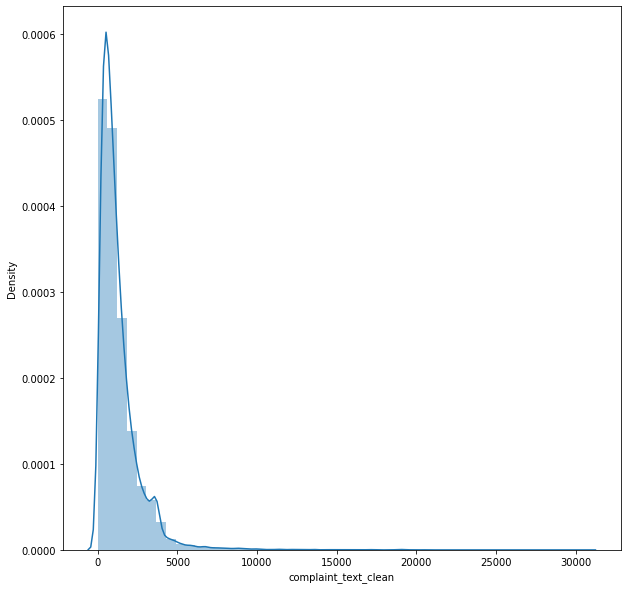

In [33]:
# Write your code here to visualise the data according to the 'Complaint' character length
sns.distplot(df_clean['complaint_text_clean'].apply(lambda x:len(x)))

#### Find the top 40 words by frequency among all the articles after processing the text.

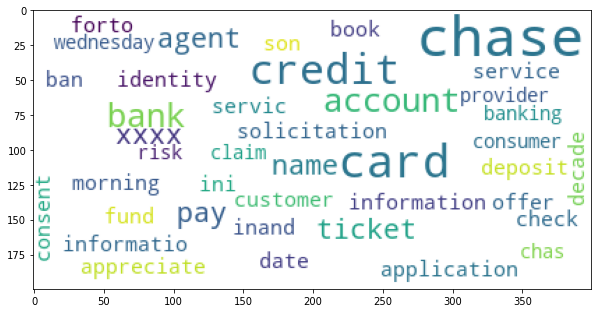

In [34]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
wordcloud = WordCloud(max_words=40, stopwords=stopwords, background_color='white', max_font_size=40).generate(str(df_clean['complaint_POS_removed']))
plt.imshow(wordcloud)

In [35]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [36]:
def get_n_gram_freq(corpus, n_gram_size=1):
  vec = CountVectorizer(ngram_range=(n_gram_size, n_gram_size), stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq

In [37]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
unigrams = get_n_gram_freq(df_clean['complaint_text_clean'], n_gram_size=1)

In [38]:
#Print the top 10 words in the unigram frequency
pd.DataFrame(unigrams[:10], columns=['unigram', 'count'])

,unigram,count
0,xxxx,187840
1,chase,78838
2,account,42317
3,credit,32087
4,xxxxxxxx,27446
5,card,26691
6,bank,26498
7,told,16326
8,did,15941
9,payment,13600


In [39]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigrams = get_n_gram_freq(df_clean['complaint_text_clean'], n_gram_size=2)

In [40]:
#Print the top 10 words in the bigram frequency
pd.DataFrame(bigrams[:10], columns=['bigram', 'count'])

,bigram,count
0,xxxx xxxx,79466
1,chase bank,12399
2,credit card,10822
3,xxxx chase,3688
4,called chase,3659
5,checking account,3526
6,credit report,3225
7,xxxxxxxx xxxx,3163
8,customer service,2996
9,xxxx xxxxxxxx,2931


In [41]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigrams = get_n_gram_freq(df_clean['complaint_text_clean'], n_gram_size=3)

In [42]:
#Print the top 10 words in the trigram frequency
pd.DataFrame(trigrams[:10], columns=['trigram', 'count'])

,trigram,count
0,xxxx xxxx xxxx,37342
1,jp morgan chase,2302
2,chase credit card,1784
3,xxxxxxxx xxxx xxxx,1583
4,xxxx xxxx chase,1495
5,xxxx xxxx xxxxxxxx,1271
6,chase xxxx xxxx,1098
7,xxxx xxxxxxxx xxxx,985
8,chase bank xxxx,949
9,account xxxx xxxx,843


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [43]:
df_clean['complaint_text_clean'] = df_clean['complaint_text_clean'].str.replace('xx+','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [44]:
#All masked texts has been removed
df_clean

,complaint_text_clean,complaint_text_lemmatized,complaint_POS_removed,Complaint_clean
0,good morning my name is and i appreciate it ...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank service ini...,morning name appreciate chase bank service ini...
1,i upgraded my card inand was told by the age...,upgraded xxxx xxxx card inand told agent upgra...,xxxx card inand agent date agent information o...,xxxx card inand agent date agent information o...
2,chase card was reported onhowever fraudulent a...,chase card reported onhowever fraudulent appli...,chase card application identity consent servic...,chase card application identity consent servic...
3,onwhile trying to book a ticket i came acr...,onwhile trying book xxxx xxxx ticket came acro...,book ticket offer forto ticket card informatio...,book ticket offer forto ticket card informatio...
4,my grand son give me check fori deposit it int...,grand son give check fori deposit chase accoun...,son check deposit chase account fund chase ban...,son check deposit chase account fund chase ban...
...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
21068,on wednesday i called chas my visa credit c...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,wednesday chas xxxx credit card provider claim...,wednesday chas xxxx credit card provider claim...
21069,i am not familiar with pay and did not unders...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase banking dea...,pay risk consumer chase bank chase banking dea...
21070,i have had flawless credit foryrs ive had chas...,flawless credit foryrs ive chase credit card c...,flawless credit chase credit card chase freedo...,flawless credit chase credit card chase freedo...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [45]:
#Write your code here to initialise the TfidfVectorizer 

tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [46]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
doc_term_mat = tfidf_vectorizer.fit_transform(df_clean['complaint_text_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [47]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [48]:
doc_topic_mat = nmf_model.fit_transform(doc_term_mat)
topic_term_mat = nmf_model.components_

In [49]:
features = np.array(tfidf_vectorizer.get_feature_names())

In [50]:
#Print the Top15 words for each of the topics
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), 
                           index=[f'Topic #{i}' for i in range(num_topics)],
                           columns=[f'Word #{i}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = topic_term_mat[i].argsort()[::-1][:15]
    topic_words.iloc[i] = features[ix]

topic_words

,Word #0,Word #1,Word #2,Word #3,Word #4,Word #5,Word #6,Word #7,Word #8,Word #9,Word #10,Word #11,Word #12,Word #13,Word #14
Topic #0,card,chase,charges,charge,dispute,called,fraud,received,did,told,merchant,claim,transaction,said,refund
Topic #1,credit,card,report,inquiry,chase,inquiries,hard,cards,reporting,score,accounts,account,removed,debt,closed
Topic #2,loan,mortgage,chase,home,modification,property,foreclosure,payments,house,jp,morgan,sale,bank,rate,letter
Topic #3,account,bank,check,chase,money,funds,checking,closed,deposit,branch,told,accounts,deposited,said,called
Topic #4,payment,late,payments,balance,paid,pay,fees,month,fee,statement,make,chase,monthly,account,charged


In [51]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
pd.DataFrame(doc_topic_mat, 
             index=[f'Doc #{i}' for i in range(doc_topic_mat.shape[0])],
             columns=[f'Topic #{i}' for i in range(num_topics)])

,Topic #0,Topic #1,Topic #2,Topic #3,Topic #4
Doc #0,0.008219,0.011507,0.026184,0.022119,0.006132
Doc #1,0.012503,0.004840,0.002031,0.005779,0.003308
Doc #2,0.010066,0.039680,0.000561,0.000000,0.000000
Doc #3,0.023340,0.045064,0.016761,0.017566,0.000000
Doc #4,0.003084,0.000000,0.002146,0.061016,0.001425
...,...,...,...,...,...
Doc #21067,0.020345,0.053581,0.000000,0.000000,0.021405
Doc #21068,0.044583,0.001543,0.003677,0.002498,0.000670
Doc #21069,0.024307,0.007219,0.005972,0.015861,0.000000
Doc #21070,0.022100,0.020156,0.002780,0.000000,0.089208


In [52]:
#Assign the best topic to each of the cmplaints in Topic Column

#write your code to assign topics to each rows.
df_clean['Topic'] = doc_topic_mat.argmax(axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [53]:
df_clean.head()

,complaint_text_clean,complaint_text_lemmatized,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is and i appreciate it ...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank service ini...,morning name appreciate chase bank service ini...,2
1,i upgraded my card inand was told by the age...,upgraded xxxx xxxx card inand told agent upgra...,xxxx card inand agent date agent information o...,xxxx card inand agent date agent information o...,0
2,chase card was reported onhowever fraudulent a...,chase card reported onhowever fraudulent appli...,chase card application identity consent servic...,chase card application identity consent servic...,1
3,onwhile trying to book a ticket i came acr...,onwhile trying book xxxx xxxx ticket came acro...,book ticket offer forto ticket card informatio...,book ticket offer forto ticket card informatio...,1
4,my grand son give me check fori deposit it int...,grand son give check fori deposit chase accoun...,son check deposit chase account fund chase ban...,son check deposit chase account fund chase ban...,3


In [54]:
#Print the first 5 Complaint for each of the Topics
df_temp=df_clean.groupby('Topic').head(5)
df_temp.sort_values('Topic')

,complaint_text_clean,complaint_text_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,i upgraded my card inand was told by the age...,upgraded xxxx xxxx card inand told agent upgra...,xxxx card inand agent date agent information o...,xxxx card inand agent date agent information o...,0
8,on i made apayment to an online retailer using...,xxxxi made apayment online retailer using chas...,xxxxi retailer pay chase website confirmation ...,xxxxi retailer pay chase website confirmation ...,0
18,chase sent me an email today with the innocuou...,chase sent email today innocuous title importa...,chase email today title information change cha...,chase email today title information change cha...,0
16,a sofa love seat table and chairs and was ne...,xxxx xxxx sofa love seat table chair never del...,sofa love seat chair debit card claim furnitur...,sofa love seat chair debit card claim furnitur...,0
14,my chase amazon card was declined for a cateri...,chase amazon card declined catering order plac...,chase card order amount chase todayand account...,chase card order amount chase todayand account...,0
2,chase card was reported onhowever fraudulent a...,chase card reported onhowever fraudulent appli...,chase card application identity consent servic...,chase card application identity consent servic...,1
3,onwhile trying to book a ticket i came acr...,onwhile trying book xxxx xxxx ticket came acro...,book ticket offer forto ticket card informatio...,book ticket offer forto ticket card informatio...,1
5,can you please remove inquiry,please remove inquiry,inquiry,inquiry,1
9,i have a chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,chase credit card credit report company issue,chase credit card credit report company issue,1
11,i have reached out to several times in attemp...,reached xxxx several time attempt fraudulent i...,time inquiry need call contact creditor report...,time inquiry need call contact creditor report...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [55]:
#Create the dictionary of Topic names and Topics

#Create the dictionary of Topic names and Topics
Topic_names = { 
                4 : 'Credit card / Prepaid card' ,
                3 : 'Bank account services',
                1 : 'Theft/Dispute reporting',
                2 : 'Mortgages/loans' , 
                0 : 'Others'
              }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [56]:
df_clean

,complaint_text_clean,complaint_text_lemmatized,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is and i appreciate it ...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank service ini...,morning name appreciate chase bank service ini...,Mortgages/loans
1,i upgraded my card inand was told by the age...,upgraded xxxx xxxx card inand told agent upgra...,xxxx card inand agent date agent information o...,xxxx card inand agent date agent information o...,Others
2,chase card was reported onhowever fraudulent a...,chase card reported onhowever fraudulent appli...,chase card application identity consent servic...,chase card application identity consent servic...,Theft/Dispute reporting
3,onwhile trying to book a ticket i came acr...,onwhile trying book xxxx xxxx ticket came acro...,book ticket offer forto ticket card informatio...,book ticket offer forto ticket card informatio...,Theft/Dispute reporting
4,my grand son give me check fori deposit it int...,grand son give check fori deposit chase accoun...,son check deposit chase account fund chase ban...,son check deposit chase account fund chase ban...,Bank account services
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Theft/Dispute reporting
21068,on wednesday i called chas my visa credit c...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,wednesday chas xxxx credit card provider claim...,wednesday chas xxxx credit card provider claim...,Others
21069,i am not familiar with pay and did not unders...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase banking dea...,pay risk consumer chase bank chase banking dea...,Others
21070,i have had flawless credit foryrs ive had chas...,flawless credit foryrs ive chase credit card c...,flawless credit chase credit card chase freedo...,flawless credit chase credit card chase freedo...,Credit card / Prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [57]:
#Create the dictionary again of Topic names and Topics

Topic_names = {  v: k for (k,v) in Topic_names.items() }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [58]:
df_clean

,complaint_text_clean,complaint_text_lemmatized,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is and i appreciate it ...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank service ini...,morning name appreciate chase bank service ini...,2
1,i upgraded my card inand was told by the age...,upgraded xxxx xxxx card inand told agent upgra...,xxxx card inand agent date agent information o...,xxxx card inand agent date agent information o...,0
2,chase card was reported onhowever fraudulent a...,chase card reported onhowever fraudulent appli...,chase card application identity consent servic...,chase card application identity consent servic...,1
3,onwhile trying to book a ticket i came acr...,onwhile trying book xxxx xxxx ticket came acro...,book ticket offer forto ticket card informatio...,book ticket offer forto ticket card informatio...,1
4,my grand son give me check fori deposit it int...,grand son give check fori deposit chase accoun...,son check deposit chase account fund chase ban...,son check deposit chase account fund chase ban...,3
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
21068,on wednesday i called chas my visa credit c...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,wednesday chas xxxx credit card provider claim...,wednesday chas xxxx credit card provider claim...,0
21069,i am not familiar with pay and did not unders...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase banking dea...,pay risk consumer chase bank chase banking dea...,0
21070,i have had flawless credit foryrs ive had chas...,flawless credit foryrs ive chase credit card c...,flawless credit chase credit card chase freedo...,flawless credit chase credit card chase freedo...,4


In [59]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaint_text_clean', 'Topic']]

In [60]:
training_data

,complaint_text_clean,Topic
0,good morning my name is and i appreciate it ...,2
1,i upgraded my card inand was told by the age...,0
2,chase card was reported onhowever fraudulent a...,1
3,onwhile trying to book a ticket i came acr...,1
4,my grand son give me check fori deposit it int...,3
...,...,...
21067,after being a chase card customer for well ove...,1
21068,on wednesday i called chas my visa credit c...,0
21069,i am not familiar with pay and did not unders...,0
21070,i have had flawless credit foryrs ive had chas...,4


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [61]:
#Write your code to get the Vector count
count_vect = CountVectorizer()
train_counts = count_vect.fit_transform(training_data['complaint_text_clean'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
train_data_tfidf = tfidf_transformer.fit_transform(train_counts)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(train_data_tfidf, training_data.Topic, test_size=0.25, random_state=50)

In [64]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

X_train (15804, 48934)
X_test (5268, 48934)
y_train (15804,)
y_test (5268,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics

### Logistic regression

In [65]:
logistic = LogisticRegression(multi_class='multinomial', solver='saga')

In [66]:
logit = logistic.fit(X_train, y_train)

In [67]:
y_pred= logit.predict(X_test)

In [68]:
accuracy_score(y_test, y_pred)

0.9470387243735763

In [69]:
print(classification_report(y_test, y_pred));

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1192
           1       0.97      0.94      0.95      1085
           2       0.96      0.94      0.95       945
           3       0.94      0.98      0.96      1412
           4       0.97      0.87      0.92       634

    accuracy                           0.95      5268
   macro avg       0.95      0.94      0.94      5268
weighted avg       0.95      0.95      0.95      5268



### Decision Tree

In [70]:
dt = DecisionTreeClassifier()

In [71]:
# hyper parameter tuning for Decision Tree
params = {
    "criterion": ["gini", "entropy"],
    "max_depth": [10,20],
    "min_samples_leaf": [5,10]
}

In [72]:
grid_search = GridSearchCV(estimator=dt,
                           param_grid=params,
                           cv=4,
                           n_jobs=-1, verbose=1, scoring="f1_weighted")

In [73]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
CPU times: user 9.04 s, sys: 264 ms, total: 9.31 s
Wall time: 2min 25s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20], 'min_samples_leaf': [5, 10]},
             scoring='f1_weighted', verbose=1)

In [74]:
grid_search.best_score_

0.7772878861216665

In [75]:
dt_best = grid_search.best_estimator_
dt_best

DecisionTreeClassifier(max_depth=20, min_samples_leaf=10)

In [76]:
y_test = dt_best.predict(X_test)

In [77]:
accuracy_score(y_test, y_pred)

0.7718299164768413

In [78]:
print(classification_report(y_test, y_pred));

              precision    recall  f1-score   support

           0       0.73      0.71      0.72      1268
           1       0.80      0.78      0.79      1074
           2       0.81      0.80      0.80       931
           3       0.80      0.84      0.82      1394
           4       0.70      0.66      0.68       601

    accuracy                           0.77      5268
   macro avg       0.77      0.76      0.76      5268
weighted avg       0.77      0.77      0.77      5268



### Random Forest

In [79]:
rf = RandomForestClassifier(max_depth=40, min_samples_leaf=5, n_estimators=400, n_jobs=-1)

In [80]:
%%time
rf.fit(X_train, y_train)

CPU times: user 1min 15s, sys: 176 ms, total: 1min 16s
Wall time: 39.4 s


RandomForestClassifier(max_depth=40, min_samples_leaf=5, n_estimators=400,
                       n_jobs=-1)

In [81]:
y_pred = rf.predict(X_test)

In [82]:
accuracy_score(y_test, y_pred)

0.7055808656036446

In [83]:
print(classification_report(y_test, y_pred));

              precision    recall  f1-score   support

           0       0.71      0.63      0.67      1268
           1       0.69      0.72      0.70      1074
           2       0.79      0.78      0.79       931
           3       0.66      0.87      0.75      1394
           4       0.78      0.33      0.47       601

    accuracy                           0.71      5268
   macro avg       0.73      0.67      0.68      5268
weighted avg       0.71      0.71      0.70      5268



### Naive Bayes

In [84]:
mnb = MultinomialNB()

In [85]:
mnb.fit(X_train, y_train)

MultinomialNB()

In [86]:
y_pred = mnb.predict(X_test)

In [87]:
accuracy_score(y_test, y_pred)

0.6002277904328018

In [88]:
print(classification_report(y_test, y_pred));

              precision    recall  f1-score   support

           0       0.64      0.56      0.60      1268
           1       0.73      0.51      0.60      1074
           2       0.78      0.66      0.71       931
           3       0.49      0.91      0.63      1394
           4       0.82      0.05      0.10       601

    accuracy                           0.60      5268
   macro avg       0.69      0.54      0.53      5268
weighted avg       0.66      0.60      0.57      5268



As observed, ***multinomial logistic regression*** has the highest metrics(accuracy, precision, recall) and has comparatively performed better than other models. 

---